In [3]:
#data
n_sample<-100
y<-numeric(n_sample)

#parameters

mu_zero<-100
mu<-numeric(n_sample)
s_w<-1000
s_v<-5000


In [4]:

set.seed(1)

mu[1]<-rnorm(n=1,mean=mu_zero,sd=sqrt(s_w))

for(i in 2:n_sample){
	mu[i]<-rnorm(n=1,mean=mu[i-1],sd=sqrt(s_w))
}

for(i in 1:n_sample){
	y[i]<-rnorm(n=1,mean=mu[i],sd=sqrt(s_v))
}


library(rstan)
library(ggplot2)


Warning message:
"package 'rstan' was built under R version 3.5.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 3.5.3"
Loading required package: StanHeaders

Warning message:
"package 'StanHeaders' was built under R version 3.5.3"
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=native')
although this causes Stan to throw an error on a few processors.



In [5]:

rstan_options(auto_write=TRUE)
options(mc.cores=parallel::detectCores())


In [6]:

data_sim<-list(y=y,n_sample=n_sample)

fit_stan_1<- stan(
	file="6-3-local-level-model.stan",
	data=data_sim,
	iter=550,
	warmup=50,
	thin=1,
	chains=4,
	seed=1
)



recompiling to avoid crashing R session

Warning message:
"There were 1868 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [7]:
options(max.print=100000)

In [8]:
print(
	fit_stan_1,
	digits=1,
	pars=c("s_w","s_v","lp__"),
	probs=c(0.025,0.5,0.975)
)

Inference for Stan model: 6-3-local-level-model.
4 chains, each with iter=550; warmup=50; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean      sd   2.5%    50%   97.5% n_eff Rhat
s_w   908.6    68.8   608.3    2.9  839.1  2398.0    78  1.0
s_v  7941.3  1544.0 10680.3 3480.8 5173.2 50028.7    48  1.1
lp__ -832.8     8.7    51.7 -886.7 -846.1  -667.9    35  1.1

Samples were drawn using NUTS(diag_e) at Tue Jun 09 12:50:53 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


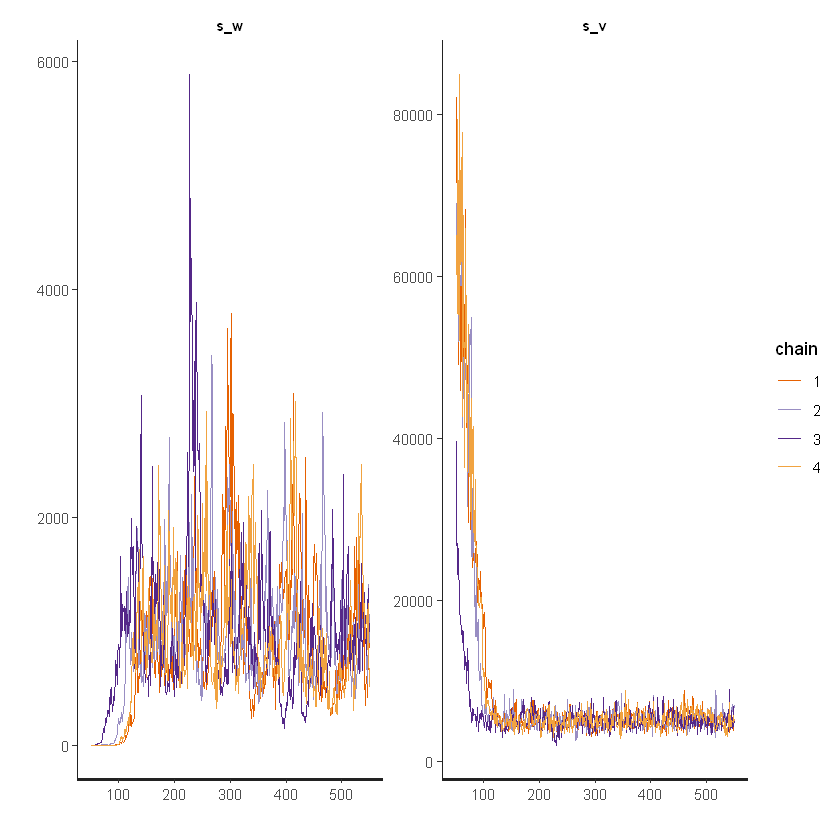

In [9]:
traceplot(fit_stan_1,pars=c("s_w","s_v"))

In [10]:
fit_stan_2<- stan(
	file="6-3-local-level-model.stan",
	data=data_sim,
	iter=5000,
	warmup=2500,
	thin=5,
	chains=4,
	seed=1
)

Warning message:
"There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


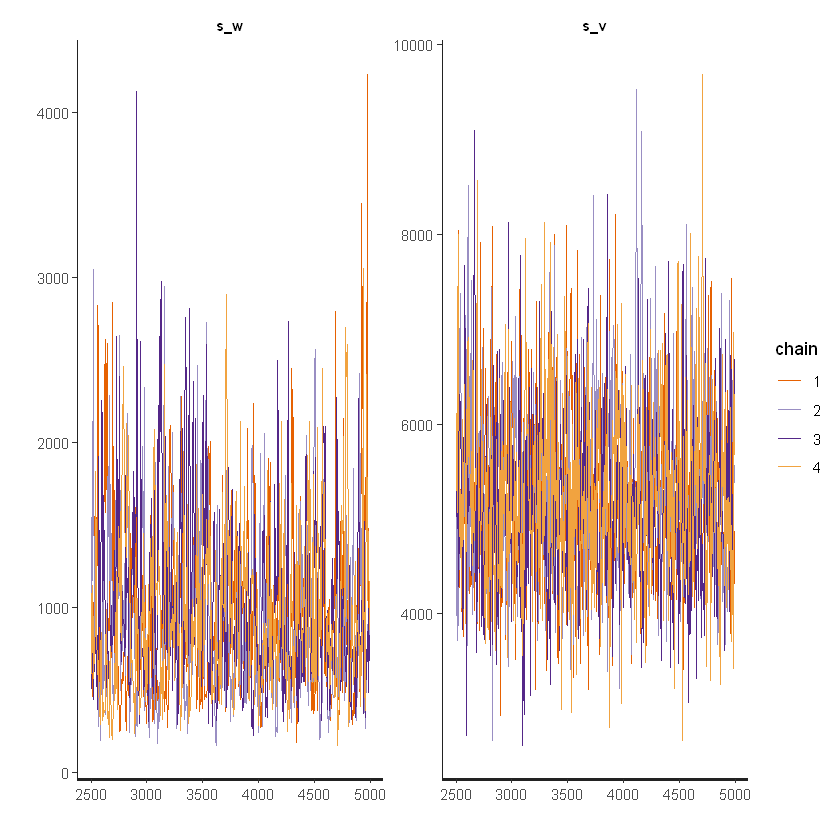

In [11]:
traceplot(fit_stan_2,pars=c("s_w","s_v"))

In [12]:
print(
	fit_stan_2,
	digits=1,
	pars=c("s_w","s_v","lp__"),
	probs=c(0.025,0.5,0.975)
)

Inference for Stan model: 6-3-local-level-model.
4 chains, each with iter=5000; warmup=2500; thin=5; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean    sd   2.5%    50%  97.5% n_eff Rhat
s_w   948.7    21.7 517.1  297.3  827.1 2272.3   567    1
s_v  5239.5    24.5 963.2 3597.8 5151.0 7438.5  1550    1
lp__ -845.8     1.0  21.5 -885.8 -846.4 -803.3   500    1

Samples were drawn using NUTS(diag_e) at Tue Jun 09 12:52:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [13]:
sampling_result<-rstan::extract(fit_stan_2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



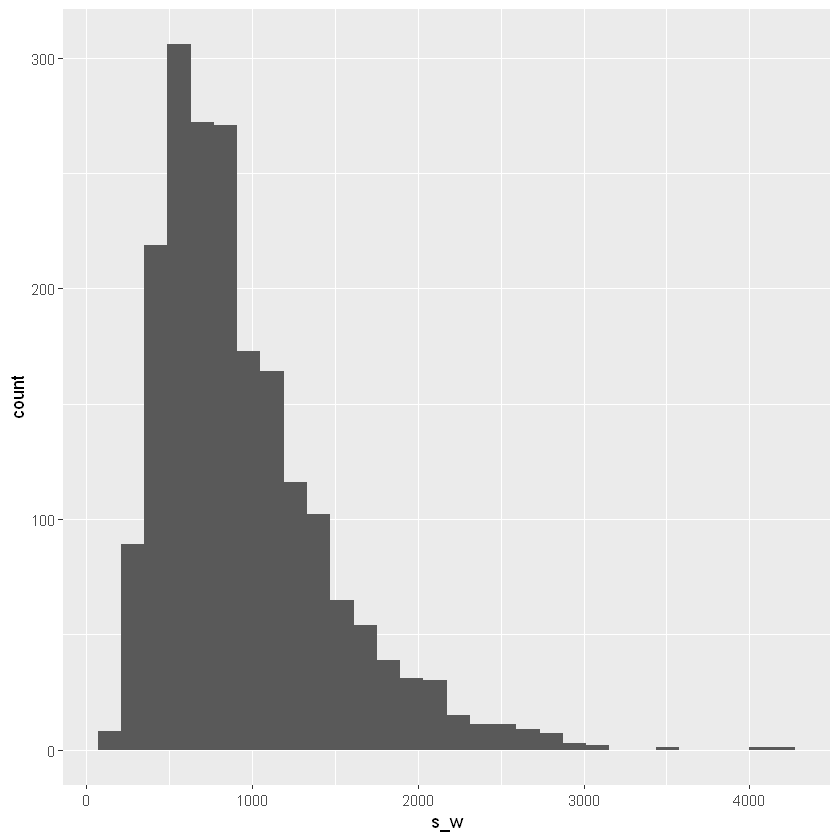

In [14]:
###histogram
ggplot(data.frame(s_w=sampling_result$s_w),aes(x=s_w))+
	geom_histogram()

In [15]:
###
model_mu<-t(apply(
	X=sampling_result$mu,
	MARGIN=2,
	FUN=quantile,
	probs=c(0.025,0.5,0.975)
))

colnames(model_mu)<- c("lwr","fit","upr")

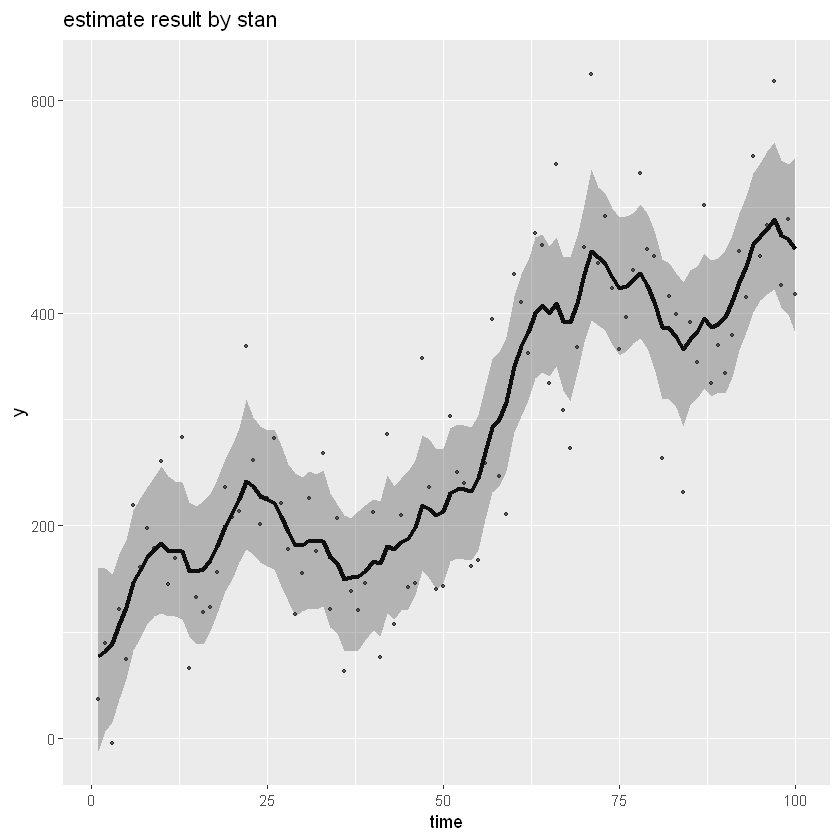

In [16]:
###
stan_df<-cbind(
	data.frame(y=y,time=1:n_sample),
	as.data.frame(model_mu)
)

ggplot(data=stan_df,aes(x=time,y=y)) +
	labs(title="estimate result by stan") +
	geom_point(alpha=0.6,size=0.9)+
	geom_line(aes(y=fit),size=1.2)+
	geom_ribbon(aes(ymin=lwr,ymax=upr),alpha=0.3)